In [3]:
import torch
import torch.nn as nn #related to neural networks
import torch.optim as optim #optimizer
from torch.utils.data import DataLoader, Dataset
import torchvision
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms, models
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
import sys
import timm
import tqdm
from PIL import Image
import json
from pycocotools.coco import COCO

import matplotlib.patches as patches
import cv2


In [4]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

mps


In [3]:
import yaml
def get_labels(yaml_file_path):
    with open(yaml_file_path, "r") as file:
        yaml_content = yaml.safe_load(file)
    return yaml_content.get("names", [])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of images: 160
Number of annotations: 201
Number of categories: 40
Image: {'file_name': 'Screenshot 2024-10-11 174314.png', 'height': 804, 'width': 811, 'id': 150}
[{'id': 191, 'image_id': 150, 'category_id': 38, 'area': 112050.0, 'iscrowd': 0, 'segmentation': [[92, 305, 507, 305, 507, 575, 92, 575]], 'bbox': [92, 305, 415, 270]}]
[[92, 305, 415, 270]]
Label: WAVETRAP_NOPOT


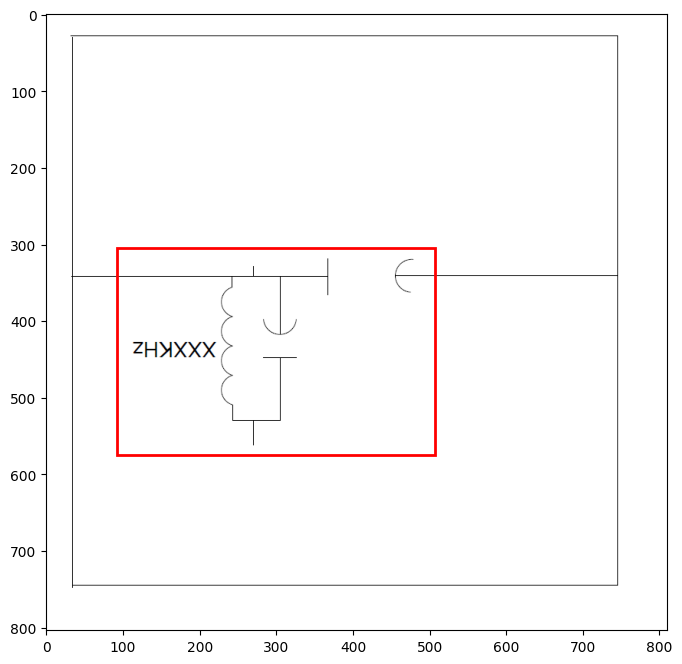

In [4]:
with open("annotations.json", "r") as file:
    coco_data = json.load(file)
coco = COCO("annotations.json")
print(f"Number of images: {len(coco_data['images'])}")
print(f"Number of annotations: {len(coco_data['annotations'])}")
print(f"Number of categories: {len(coco_data['categories'])}")

x = 150
# Load a specific image by ID
image = coco.loadImgs(x)[0]
print(f"Image: {image}")

annotations = coco.loadAnns(coco.getAnnIds(imgIds=x))
print(annotations)
bounding_boxes = [ann['bbox'] for ann in annotations]
print(bounding_boxes)
label = coco.loadCats([annotations[0]['category_id']][0])[0]['name']
print(f"Label: {label}")

# Load the image
image_path = "images/" + image['file_name']
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Add bounding boxes
for ann in annotations:
    bbox = ann['bbox']  # [x, y, width, height]
    rect = patches.Rectangle(
        (bbox[0], bbox[1]),
        bbox[2],
        bbox[3],
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.show()


# Create Circuit Diagram Dataset

In [5]:
class CircuitDiagramDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.ann_dir = os.path.join('annotations.json')
        self.image_dir = image_path
        self.transform = transform        
        self.coco = COCO("annotations.json")
    
    def __len__(self):
        return len(self.coco.getImgIds())
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.coco.loadImgs(idx)[0]['file_name'])
        
        # Load the image using PIL
        image = Image.open(img_path).convert("RGB")
        image_id = self.coco.loadImgs(idx)[0]['id']
        
        # Get annotation IDs for the image
        ann_ids = self.coco.getAnnIds(imgIds=idx)
        annotations = self.coco.loadAnns(ann_ids)
        
        # Prepare the annotations (usually bounding boxes and category labels)
        boxes = []
        labels = []
        for ann in annotations:
            bbox = ann['bbox']  # [x, y, width, height]
            bbox[2] += bbox[0]  # x + width
            bbox[3] += bbox[1]  # y + height
            category_id = ann['category_id']
            boxes.append(bbox)
            labels.append(category_id)
        
        # Convert boxes and labels to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Apply the transformations (if any)
        if self.transform:
            image = self.transform(image)
        
        original_width, original_height = self.coco.loadImgs(idx)[0]['width'], self.coco.loadImgs(idx)[0]['height']
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        for i in range(len(boxes)):
            boxes[i][0] *= scale_x  # x
            boxes[i][1] *= scale_y  # y
            boxes[i][2] *= scale_x  # width
            boxes[i][3] *= scale_y  # height
        
        # Create a target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id])
        }
        
        # Return the image along with the bounding boxes and labels
        return image, target
    
    
    

In [6]:
def plot_image_with_boxes(image, boxes):
    # Convert image tensor to a numpy array (from [C, H, W] to [H, W, C] and denormalize if necessary)
    image = image.permute(1, 2, 0).numpy()
    image = (image * 255).astype("uint8")  # Denormalize if the image was normalized earlier
    
    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(10, 8))
    
    # Display the image
    ax.imshow(image)
    
    # Add bounding boxes
    for box in boxes:
        xmin, ymin, xmax, ymax = map(int, box)
        rect = patches.Rectangle(
            (xmin, ymin),  # Starting point (x, y)
            xmax - xmin,   # Width
            ymax - ymin,   # Height
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
    
    # Show the plot
    plt.show()
    

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Image directory: 160
Image shape: torch.Size([3, 224, 224])
Boxes: tensor([[104.1983,  84.8900, 119.2727,  99.1296]])
Labels: CAP


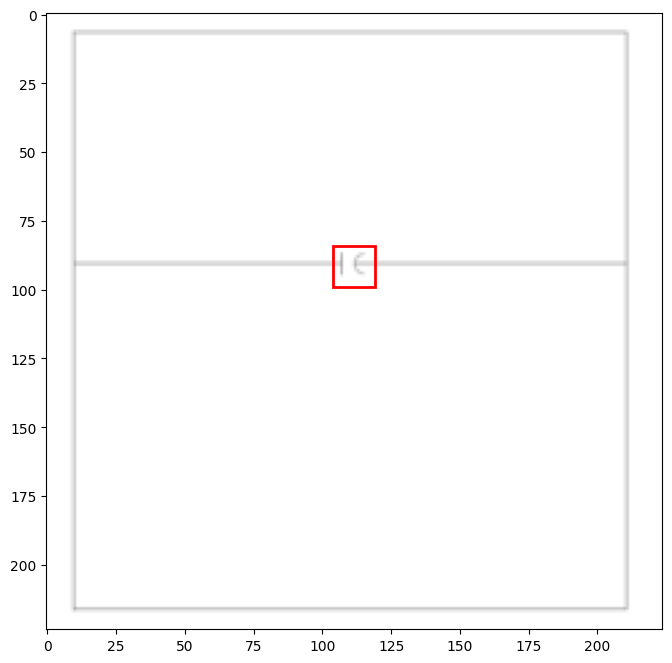

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test = CircuitDiagramDataset(    
    image_path="images",
    transform=transform)

image, target = test[41]
boxes = target["boxes"]
labels = target["labels"]
print(f"Image directory: {len(test.coco.getImgIds())}")
print(f"Image shape: {image.shape}")
print(f"Boxes: {boxes}")    
print(f"Labels: {test.coco.loadCats(labels.numpy())[0]['name']}")
plot_image_with_boxes(image, boxes)

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train = CircuitDiagramDataset(    
    image_path="images",
    transform=transform)

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

train_dataloader = DataLoader(train, batch_size=4, shuffle=True, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Defining Model

In [9]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes=40):
    # Where we define all the parts of the model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [10]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# Training

In [5]:
model = get_model(num_classes=41)
model.to(device)
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0.0

    for images, targets in tqdm.tqdm(data_loader, desc=f"Epoch {epoch}"):
        # Ensure valid images and targets
        valid_samples = []
        for image, target in zip(images, targets):
            if target["image_id"].item() == 0:  # Skip image_id=0
                continue
            valid_samples.append((image, target))

        # Skip if no valid samples
        if not valid_samples:
            continue

        # Separate valid images and targets
        images = [sample[0].to(device) for sample in valid_samples]
        targets = [{k: v.to(device) for k, v in sample[1].items()} for sample in valid_samples]

        try:
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass and optimization
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()

        except Exception as e:
            print(f"Error in processing batch: {e}")
            continue

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")

# Define optimizer and learning rate scheduler
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Train the model for a few epochs
num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_dataloader, device, epoch)
    lr_scheduler.step()

NameError: name 'get_model' is not defined

In [5]:
from ultralytics import YOLO

# Load a pre-trained YOLO model
model = YOLO("yolov8n.pt")  # Use 'yolov8s', 'yolov8m', etc., for larger models

# Train the model
results = model.train(data="./data.yaml", epochs=10, imgsz=640, device=device)


metrics = model.val()
print(metrics.box.map)  # mAP50-95

New https://pypi.org/project/ultralytics/8.3.68 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /Users/enerinn/Developer/CS25-338-main/Model/labels/train.cache... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]
val: Scanning /Users/enerinn/Developer/CS25-338-main/Model/labels/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]


Plotting labels to /Users/enerinn/Developer/CS25-338-main/runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000227, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/enerinn/Developer/CS25-338-main/runs/detect/train9
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.58G      2.459      7.063      1.732         20        640: 100%|██████████| 10/10 [00:25<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.33s/it]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.62G      1.971      6.409      1.463         19        640: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.64G      1.661      6.022      1.335         18        640: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.64G      1.599      5.882      1.287         21        640: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.65G      1.463      5.639      1.153         16        640: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.67G      1.382      5.428      1.112         19        640: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

                   all         40         56     0.0167       0.05     0.0498     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.67G      1.352      5.265      1.094         16        640: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.93s/it]

                   all         40         56     0.0292      0.171     0.0726     0.0479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.69G      1.327      5.142        1.1         18        640: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]

                   all         40         56     0.0379      0.431      0.124     0.0878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       4.7G      1.349      5.124      1.092         18        640: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.91s/it]

                   all         40         56     0.0295      0.598      0.148       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.74G      1.312      5.001       1.09         21        640: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.60s/it]

                   all         40         56     0.0313      0.775      0.203      0.155



10 epochs completed in 0.046 hours.
Optimizer stripped from /Users/enerinn/Developer/CS25-338-main/runs/detect/train9/weights/last.pt, 6.3MB
Optimizer stripped from /Users/enerinn/Developer/CS25-338-main/runs/detect/train9/weights/best.pt, 6.3MB

Validating /Users/enerinn/Developer/CS25-338-main/runs/detect/train9/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.12.6 torch-2.5.1 MPS (Apple M2)
Model summary (fused): 168 layers, 3,013,448 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


                   all         40         56     0.0319      0.775       0.19      0.145
                  25FP          1          2     0.0417          1      0.297      0.263
                  30FP          1          3       0.06          1     0.0654     0.0414
                  35FP          1          3        0.3          1      0.863      0.657
            38BRKR_ATT          1          2     0.0211          1     0.0836     0.0669
                  40FP          1          4      0.103          1      0.141      0.113
                  45FP          1          3     0.0612          1      0.332      0.299
                50FPUP          1          1      0.012          1      0.249      0.199
                 Arrow          1          1     0.0119          1     0.0231    0.00926
              AUTOXFMR          1          1     0.0714          1      0.497      0.448
              BRKR_ATT          1          1     0.0192          1     0.0829      0.058
                   CA

val: Scanning /Users/enerinn/Developer/CS25-338-main/Model/labels/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


                   all         40         56     0.0275      0.725      0.162      0.124
                  25FP          1          2     0.0408          1      0.538      0.481
                  30FP          1          3     0.0612          1     0.0609     0.0453
                  35FP          1          3      0.231          1      0.789      0.599
            38BRKR_ATT          1          2      0.022          1      0.082     0.0574
                  40FP          1          4     0.0976          1      0.171      0.136
                  45FP          1          3       0.06          1      0.336      0.302
                50FPUP          1          1     0.0118          1      0.249      0.199
                 Arrow          1          1     0.0127          1     0.0226    0.00905
              AUTOXFMR          1          1     0.0714          1      0.497      0.448
              BRKR_ATT          1          1     0.0196          1      0.111     0.0774
                   CA